<a href="https://colab.research.google.com/github/blankon123/random-analytics/blob/main/Messy_VS_Tidy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cek versi Tensorflow
import tensorflow as tf

print(tf.__version__)

2.6.0


In [2]:
#Download dataset dari kaggle
from google.colab import files

files.upload()

! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d cdawn1/messy-vs-clean-room

Saving kaggle.json to kaggle.json
 77% 52.0M/67.1M [00:00<00:00, 51.1MB/s]
100% 67.1M/67.1M [00:00<00:00, 91.3MB/s]


In [3]:
#Ekstraksi zip
from IPython.display import clear_output

!unzip -qq messy-vs-clean-room.zip

clear_output()
!ls images/images

test  train  val


In [9]:
#Pemeriksaan nama kelas
import os
image_path = '/content/images/images/train/'
kelas = os.listdir(image_path)

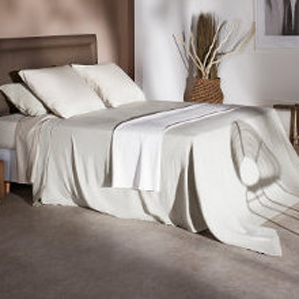

(299, 299, 3) clean/65.png


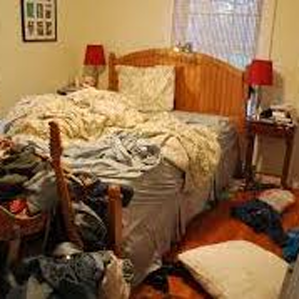

(299, 299, 3) messy/65.png


In [10]:
import cv2 as cv 
from google.colab.patches import cv2_imshow
from skimage import io

#Menampilkan beberapa contoh gambar
lokasis = [k+'/'+os.listdir(image_path+k)[1] for k in kelas]

for lokasi in lokasis:
  image = io.imread(image_path+lokasi) 
  image_2 = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  cv2_imshow(image_2)
  print(image_2.shape, lokasi)

In [11]:
#Pemeriksaan nama kelas
import os
image_path = 'images/images/train'
daftar_kelas = os.listdir(image_path)
daftar_kelas

['clean', 'messy']

In [12]:
#Kelas pilihan
kelas = daftar_kelas

#Jumlah sampel gambar
sample_number = 0

for k in kelas:
  totalFiles = 0
  for base, dirs, files in os.walk(image_path+'/'+k):
      for Files in files:
          totalFiles += 1
  print('Total Files di',k,totalFiles)
  sample_number += totalFiles

print('Total Training ',sample_number)
print('Total Kelas ',len(kelas))

Total Files di clean 96
Total Files di messy 96
Total Training  192
Total Kelas  2


In [13]:
import os

base_dir = '/content/images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [14]:
print(os.listdir(train_dir))
print(os.listdir(validation_dir))

['clean', 'messy']
['clean', 'messy']


In [15]:
# menyimpan direktori ruangan rapi pada direktori data training
train_clean_dir = os.path.join(train_dir, 'clean')
 
# menyimpan direktori ruangan berantakan pada direktori data training
train_messy_dir = os.path.join(train_dir, 'messy')
 
# menyimpan direktori ruangan rapi pada direktori data validasi
validation_clean_dir = os.path.join(validation_dir, 'clean')
 
# menyimpan direktori ruangan berantakan pada direktori data validasi
validation_messy_dir = os.path.join(validation_dir, 'messy')

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [45]:
ukuran_target = (300,300)
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=ukuran_target,  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4,
        # karena kita merupakan masalah klasifikasi 2 kelas maka menggunakan class_mode = 'binary'
        class_mode='binary')
 
validation_generator = test_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=ukuran_target, # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4, # karena kita merupakan masalah klasifikasi 2 kelas maka menggunakan class_mode = 'binary'
        class_mode='binary')

Found 192 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [59]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       1

In [23]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# tf.keras.backend.clear_session()

# model = tf.keras.models.Sequential([
#     InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dense(4, activation='relu'),
#     tf.keras.layers.Dropout(0.5), 
#     tf.keras.layers.Dense(1, activation='softmax')
# ])

# model.layers[0].trainable = False

# model.summary()

In [60]:
# compile model dengan 'adam' optimizer loss function 'binary_crossentropy' 
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [61]:
#Karena proses training berjalan lama, diperlukan callback agar ketika goal tercapai (Akurasi>92) , epoch selanjutnya tidak diperlukan
acc = 0.89

class myCallback(tf.keras.callbacks.Callback): 
  def on_epoch_end(self, epoch, logs={}): 
    if(logs.get('val_accuracy')>=acc and logs.get('accuracy')>=acc): 
      print("\ACC >",acc,"!") 
      self.model.stop_training = True 

callbacks = myCallback() 

In [62]:
# latih model dengan model.fit 
history = model.fit(
      train_generator,
      steps_per_epoch=30,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=40, # tambahkan epochs jika akurasi model belum optimal
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      callbacks=[callbacks], #Aktivasi callback jika sudah sesuai keinginan
      verbose=2)

Epoch 1/40
30/30 - 29s - loss: 0.7671 - accuracy: 0.5000 - val_loss: 0.7047 - val_accuracy: 0.5000
Epoch 2/40
30/30 - 28s - loss: 0.6698 - accuracy: 0.6333 - val_loss: 0.6396 - val_accuracy: 0.5500
Epoch 3/40
30/30 - 28s - loss: 0.6031 - accuracy: 0.6333 - val_loss: 0.5528 - val_accuracy: 0.7500
Epoch 4/40
30/30 - 27s - loss: 0.6640 - accuracy: 0.5833 - val_loss: 0.6763 - val_accuracy: 0.6500
Epoch 5/40
30/30 - 27s - loss: 0.6618 - accuracy: 0.6167 - val_loss: 0.6239 - val_accuracy: 0.7000
Epoch 6/40
30/30 - 28s - loss: 0.5972 - accuracy: 0.7167 - val_loss: 0.6068 - val_accuracy: 0.6500
Epoch 7/40
30/30 - 28s - loss: 0.6656 - accuracy: 0.6000 - val_loss: 0.6302 - val_accuracy: 0.7000
Epoch 8/40
30/30 - 27s - loss: 0.5264 - accuracy: 0.7167 - val_loss: 0.7696 - val_accuracy: 0.6000
Epoch 9/40
30/30 - 27s - loss: 0.6303 - accuracy: 0.6750 - val_loss: 0.6419 - val_accuracy: 0.6000
Epoch 10/40
30/30 - 28s - loss: 0.5043 - accuracy: 0.7667 - val_loss: 0.3734 - val_accuracy: 0.8000
Epoch 11/

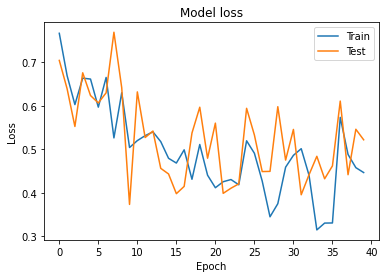

In [63]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train','Test'], loc='upper right') 
plt.show() 

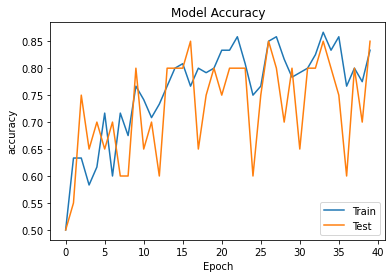

In [64]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('Model Accuracy')
plt.ylabel('accuracy') 
plt.xlabel('Epoch') 
plt.legend(['Train','Test'], loc='lower right') 
plt.show() 

In [68]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


Saving Messy2.jpg to Messy2 (3).jpg
Messy2.jpg
messy


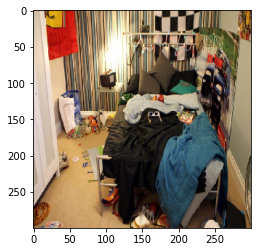

In [73]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(300,300))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes==0:
    print('clean')
  else:
    print('messy')

In [ ]:
# Konversi model. 
converter = tf.lite.TFLiteConverter.from_keras_model(model) 
tflite_model = converter.convert() 

#Serialize model ke file 
with tf.io.gfile.GFile('/content/model.tflite', 'wb') as f: 
  f.write(tflite_model) 

INFO:tensorflow:Assets written to: /tmp/tmpckk2r6mx/assets


INFO:tensorflow:Assets written to: /tmp/tmpckk2r6mx/assets
